In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Perceptrons are artificial neurons that are roughly modeled on neurobiology. The perceptron can be conceptualized as a body, which receives some number of weighted inputs. This body performs the weighted summation of these weights and inputs, passing this value to an activation function. For a perceptron, the activation function is simply the step function, i.e if the input exceeds some threshold value, return 1, else 0.

In [2]:
# import dataset
import dataset

# Our dataset uses chars and not number values: encode the values
def encode(data):
    return [1 if pixel == '#' else 0
               for line in data
               for pixel in line]

train_set = [encode(d) for d in dataset.TRAINING_DATA]
test_set = [encode(d) for d in dataset.TEST_DATA]

# Project document says that the data is 5x7...columns x rows
print(np.reshape(train_set[0], (5,7)))

# But numpy reshape wants rows x columns
print(np.reshape(train_set[0], (7,5)))

[[0 1 1 1 0 1 0]
 [0 0 1 1 0 0 0]
 [1 1 0 0 0 1 1]
 [1 1 1 1 1 0 0]
 [0 1 1 0 0 0 1]]
[[0 1 1 1 0]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 1 1 1 1]
 [1 0 0 0 1]
 [1 0 0 0 1]]


Now that we have our data, we can do some superficial analysis to make sure we are on the right track. Our goal is to implement a perceptron for each letter of the English alphabet, for a total of 26 perceptrons.

In [3]:
print(f'len(train_set): {len(train_set)}')
print(f'len(test_set): {len(test_set)}')

len(train_set): 26
len(test_set): 26


This looks good so far. We need to implement 26 perceptrons, and we have 26 items in both the training set and testing sets.

Now we can check the length of our input vector for our letter classifying perceptron.

In [4]:
print(f'len(input_vector): {len(train_set[0])}')

len(input_vector): 35


The letters we are using for our training and testing data are structured as 7x5 blocks, so this seems to check out as well.

Now that we know the length of our input vector, we can initialize our weights vector.

NOTE: In the perceptron model, there is an additional bias input, which is always a weighted +1. We will need to account for this by adding an extra weight to our weight vector, and an extra input +1 to the input vector.

In [5]:
input_vector = [1] + train_set[0]         # add bias to front of input vector
input_vector = np.asarray(input_vector)   # lets read everything in as numpy arrays now

np.random.seed(1)  # for testing purposes
weight_vector = np.random.uniform(-1, 1, len(input_vector))  # initialize random weights
print(weight_vector)

[-0.16595599  0.44064899 -0.99977125 -0.39533485 -0.70648822 -0.81532281
 -0.62747958 -0.30887855 -0.20646505  0.07763347 -0.16161097  0.370439
 -0.5910955   0.75623487 -0.94522481  0.34093502 -0.1653904   0.11737966
 -0.71922612 -0.60379702  0.60148914  0.93652315 -0.37315164  0.38464523
  0.7527783   0.78921333 -0.82991158 -0.92189043 -0.66033916  0.75628501
 -0.80330633 -0.15778475  0.91577906  0.06633057  0.38375423 -0.36896874]


Once we have our two vectors describing the perceptron network, we can start modeling the rest. Right now we have inputs and their associated weights. With these, we can compute a weighted sum of all the inputs into the perceptron.

In [6]:
weighted_sum = np.dot(weight_vector, input_vector)

print(weight_vector.transpose())
print('-'*80)
print(input_vector)
print('-'*80)
print(weighted_sum)

[-0.16595599  0.44064899 -0.99977125 -0.39533485 -0.70648822 -0.81532281
 -0.62747958 -0.30887855 -0.20646505  0.07763347 -0.16161097  0.370439
 -0.5910955   0.75623487 -0.94522481  0.34093502 -0.1653904   0.11737966
 -0.71922612 -0.60379702  0.60148914  0.93652315 -0.37315164  0.38464523
  0.7527783   0.78921333 -0.82991158 -0.92189043 -0.66033916  0.75628501
 -0.80330633 -0.15778475  0.91577906  0.06633057  0.38375423 -0.36896874]
--------------------------------------------------------------------------------
[1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 0 0 1]
--------------------------------------------------------------------------------
-1.5791311261411078


The next part we need to add into our perceptron model is the activation function, i.e a threshold. If the weighted sum of all inputs to the network exceeds some threshold value ouput +1, else output 0.

In [7]:
threshold = 0
prediction = 1 if weighted_sum > threshold else 0
print(f'Network predicts {prediction} given ({weighted_sum}) weighted sum.')

Network predicts 0 given (-1.5791311261411078) weighted sum.


We almost have all of the building blocks we need to implement a perceptron. Now we need to figure out how to make the perceptron "learn". That is, we need to compare our prediction to the target value, and update our weights accordingly.

To do this, first we'll need to define the labels for correctly classifying each letter. Right now let's just quickly build it manually. We can automate this process, for this specific problem, later when we're ready to turn this into an implementation.

In [8]:
class Perceptron:
    def __init__(self, weights, learning_rate=0.1, threshold=0):
        self.weights = weights
        self.learning_rate = learning_rate
        self.threshold = threshold
        self.misclasses = []  # store these locally so we can plot each perceptron's learning after training
    
    def predict(self, inputs):
        # inputs[0] == 1 (i.e bias), no need to separately add self.weights[0]
        weighted_sum = np.dot(self.weights, inputs)
        return (1, weighted_sum) if weighted_sum > self.threshold else (0, weighted_sum)
    
    def train(self, inputs, labels, epochs=100):
        training = True
        while epochs > 0 and training:
            training = False
            miss_count = 0
            
            for inp, lab in zip(inputs, labels):
                prediction, wsum = self.predict(inp)
                #print(f'prediction: {prediction}\twsum:{wsum}')
                error = lab - prediction
                
                if error != 0:
                    training = True
                    miss_count += 1

                    for idx in range(len(inp)):
                        self.weights[idx] = self.weights[idx] + self.learning_rate * (error*inp[idx])
                        
            self.misclasses.append(miss_count)
            epochs -= 1
            
    def plot(self, letter_classifier):
        fig, ax = plt.subplots()
    
        ax.set(xlabel='Number of Epochs', ylabel='Number of Misclassifications',
           title=f'Perceptron {letter_classifier}')
    
        # self.misclasses: [Int] -- a list of integers, representing the number of misclassifications for each epoch i
        # the length of self.misclasses is the total number of epochs the perceptron took to train
        xaxis = np.arange(0, len(self.misclasses), 1)
        yaxis = self.misclasses
        ax.plot(xaxis, yaxis)
        plt.show()
        

In [9]:
letters = [ch for ch in 'abcdefghijklmnopqrstuvwxyz']

# Setup labels vector for recognizing 'A'
a_labels = [0] * len(train_set)
a_labels[0] = 1

In [10]:
# build the labels for all letters
all_labels = [ np.roll(a_labels, i) for i in range(len(a_labels)) ]

print(all_labels[0])   # 'A'
print(all_labels[1])   # 'B'
print(all_labels[2])   # 'C'

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [11]:
# map each label vector with its appropriate letter for convenience if we ever need to access by character
label_dict = {letter : labels for (letter,labels) in zip(letters,all_labels)}

print(label_dict['z'])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]


In [12]:
# Add +1 bias to beginning of all input vectors in training set
inputs = [[1] + train_set[i] for i in range(len(train_set))] 
input_dict = {ch : inp for ch, inp in zip(letters, inputs)}

We add a bias of +1 to the beginning of each input vector so that we don't need to manually manage the bias when performing the weighted sum. We treat the bias as just another weighted input (i.e perceptron.weights[0] and inputs[0][0]).

In [14]:
# load in testing set
test_inputs = [[1] + test_set[i] for i in range(len(test_set))]
test_input_dict = {ch : test for (ch, test) in zip(letters, test_inputs)}

# make the perceptrons and store them in a dict for easy reference
np.random.seed(1)
perceptrons = [ Perceptron(np.random.uniform(-1, 1, (len(inputs[0])))) for i in range(len(inputs)) ]
perceptron_dict = {ch : p for (ch, p) in zip(letters, perceptrons)}

for ch in letters:
    p = perceptron_dict[ch]
    #print(f'initial weights: {"*" * 60}\n{np.reshape(p.weights[1:], (7,5))}\nbias: {p.weights[0]}')
    p.train(input_dict.values(), label_dict[ch], epochs=100)
    """
    p.plot(ch)
    for l in letters:
        print(f'{ch} vs {l} = {p.predict(input_dict[l])}')
    """
p_a = perceptron_dict['a']

for classifier, p in perceptron_dict.items():
    print(f'Testing \'{classifier}\'\n{"-" * 40}')
    for ch, test in test_input_dict.items():
        prediction, wsum = p.predict(test)
        if prediction > 0:
            print(f' {classifier} vs {ch} : {prediction} ({wsum})')
    print(f'{"-" * 40}')

Testing 'a'
----------------------------------------
 a vs a : 1 (1.9849738131208545)
 a vs j : 1 (0.25791681245734155)
----------------------------------------
Testing 'b'
----------------------------------------
 b vs j : 1 (0.49949260208004975)
 b vs s : 1 (0.08746623745170934)
----------------------------------------
Testing 'c'
----------------------------------------
 c vs c : 1 (1.2176577779925306)
 c vs g : 1 (0.16381953571112584)
 c vs n : 1 (0.04448407339020044)
 c vs y : 1 (0.1362867974372589)
----------------------------------------
Testing 'd'
----------------------------------------
 d vs a : 1 (1.2161187636169652)
----------------------------------------
Testing 'e'
----------------------------------------
 e vs x : 1 (0.4140145298390193)
----------------------------------------
Testing 'f'
----------------------------------------
 f vs f : 1 (0.7439662480014072)
 f vs x : 1 (1.553287157420119)
----------------------------------------
Testing 'g'
------------------------

In [97]:
   

#for ch in letters:
#    print(perceptron_dict[ch].weights)

#for inp, weight in zip(inputs[0], perceptron_dict['a'].weights):
#    print(f'{inp} : {weight}')
#for (letter, p) in perceptron_dict.items():
#    for ch, train in zip(letters, input_dict.values()):
#        output = p.predict(test)
#        print(f'Classifier for {letter} vs {ch} : {output}')
#    print(f'{"*" * 80}')
        
for (letter, p) in perceptron_dict.items():
    for ch, test in zip(letters,test_inputs):
        #print(f'{np.reshape(input_dict[letter][1:], (7,5))} : TRAIN')
        #print(f'{"-" * 40}')
        #print(f'{np.reshape(test[1:],(7,5))} : TEST')
        
        output = p.predict(test)
        
        #print(f'{letter} vs {ch}: {output}')
    #print(f'{"*" * 80}')
print(np.reshape(perceptron_dict['b'].weights[1:], (7,5)))
print(np.reshape(input_dict['b'][1:], (7,5)))
print(f'{"-" * 20}')
print(np.reshape(test_input_dict['b'][1:], (7,5)))

[[ 0.76925134 -1.16342345  0.20028863  0.67772218 -0.30366869]
 [-0.53911202  0.57855866 -0.89354799 -0.20421295  0.51719101]
 [-0.5127717  -0.42444932 -0.83994286 -1.36126608  0.45767107]
 [-0.57674377  0.13109332  0.18314632 -0.39327491 -0.45176479]
 [-0.70654285 -0.12138893  0.29951672 -0.89533114  0.02811198]
 [-0.01119968 -0.17164146 -1.00009308 -0.02820719  0.42758929]
 [ 0.32977822  0.48918951 -0.22688992  0.50680383 -1.02505059]]
[[1 1 1 1 0]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 1 1 1 0]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 1 1 1 0]]
--------------------
[[0 1 1 1 0]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 1 1 1 0]
 [1 0 0 0 1]
 [1 0 0 0 1]
 [1 1 1 1 0]]


       0    1    2    3               4
0    5.1  3.5  1.4  0.2     Iris-setosa
1    4.9  3.0  1.4  0.2     Iris-setosa
2    4.7  3.2  1.3  0.2     Iris-setosa
3    4.6  3.1  1.5  0.2     Iris-setosa
4    5.0  3.6  1.4  0.2     Iris-setosa
..   ...  ...  ...  ...             ...
145  6.7  3.0  5.2  2.3  Iris-virginica
146  6.3  2.5  5.0  1.9  Iris-virginica
147  6.5  3.0  5.2  2.0  Iris-virginica
148  6.2  3.4  5.4  2.3  Iris-virginica
149  5.9  3.0  5.1  1.8  Iris-virginica

[150 rows x 5 columns]


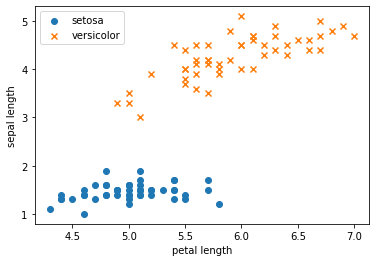

In [98]:
# lets verify this perceptron algorithm works on some data we can visualize...
import pandas as pd

def load_data():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
    data = pd.read_csv(url, header = None)
    print(data)
    
    data = data[:100]
    data[4] = np.where(data.iloc[:, -1] =='Iris-setosa', 0, 1)
    data = np.asmatrix(data, dtype = 'float64')
    return data

data = load_data()

plt.scatter(np.array(data[:50,0]), np.array(data[:50,2]), marker='o', label='setosa')
plt.scatter(np.array(data[50:,0]), np.array(data[50:,2]), marker='x', label='versicolor')
plt.xlabel('petal length')
plt.ylabel('sepal length')
plt.legend()
plt.show()

[6, 5, 5, 3, 4, 3, 3, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 1, 0, 0]


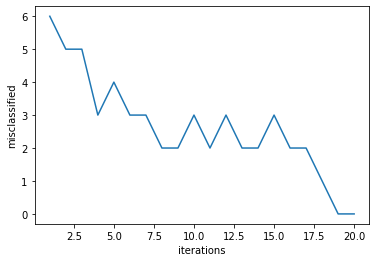

In [99]:
features = data[:, :-1]
    
np.random.seed(1)
w = np.random.uniform(-1, 1, features.shape[1]+1)
#print(w)
#w = np.zeros(features.shape[1]+1)
#print(w)
features = np.asarray([[1] + feature for feature in features])

labels =  data[:, -1]

example_perceptron = Perceptron(w)

epochs = 20
misclassified = []

for epoch in range(epochs):
    misclasses = 0
    for x, l in zip(features, labels):
        x = np.insert(x,0,1)
        pred = np.dot(example_perceptron.weights, x)
        out = 1 if pred > 0 else 0
        err = l - out

       # print(f'features: {x}\nweights: {example_perceptron.weights}\nprediction: {pred}\noutput: {out}\nlabel: {l}\nerror: {err}\n{"*" * 60}\n')
        if err != 0:
            misclasses += 1
            for i in range(len(x)):
                example_perceptron.weights[i] = example_perceptron.weights[i] + (0.01 * (err * x[i]))
    misclassified.append(misclasses)

print(misclassified)
plt.plot(np.arange(1,epochs+1), misclassified)
plt.xlabel('iterations')
plt.ylabel('misclassified')
plt.show()
#for i in range(len(features)):
 #   print(example_perceptron.predict(np.insert(features[i],0,1)))
    #example_perceptron.train(x, labels)